In [1]:
# Upload the dataset of the project to the virtual env just for the first time.
# import zipfile
# with zipfile.ZipFile('dog-breed-identification (1).zip', 'r') as zip_ref:
#     zip_ref.extractall('Dog Breed Dataset/')


## End-to-End multi class Dog Breed Classification

This Notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.


## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

Some infromation about the data:

* We're dealing with images(ustructured data) so it's probably best we use deep learning/transfer learning.

* There are 120 breeds of dogs(this means there are 120 different classes)

* There are around 10,000+ images in training set ( These images have labels).

* There are around 10,000+ images in the test set (These images have no labels, because we'll want to predict them.)

In [2]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("TF Hub Version: ", hub.__version__)



2024-06-28 13:46:43.017829: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-28 13:46:43.055900: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-28 13:46:44.492261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TF version:  2.16.1
TF Hub Version:  0.16.1


In [3]:
# Check for GPU availability
print("GPU", "Available" if tf.config.list_physical_devices("GPU") else print("Not Available"))


GPU Available


## Getting our data ready (truning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's waht we'll be doing first. Turning our images into Tensors(Numerical representations).

Let's start by accessing our data and checking out the labels.

In [4]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


In [5]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

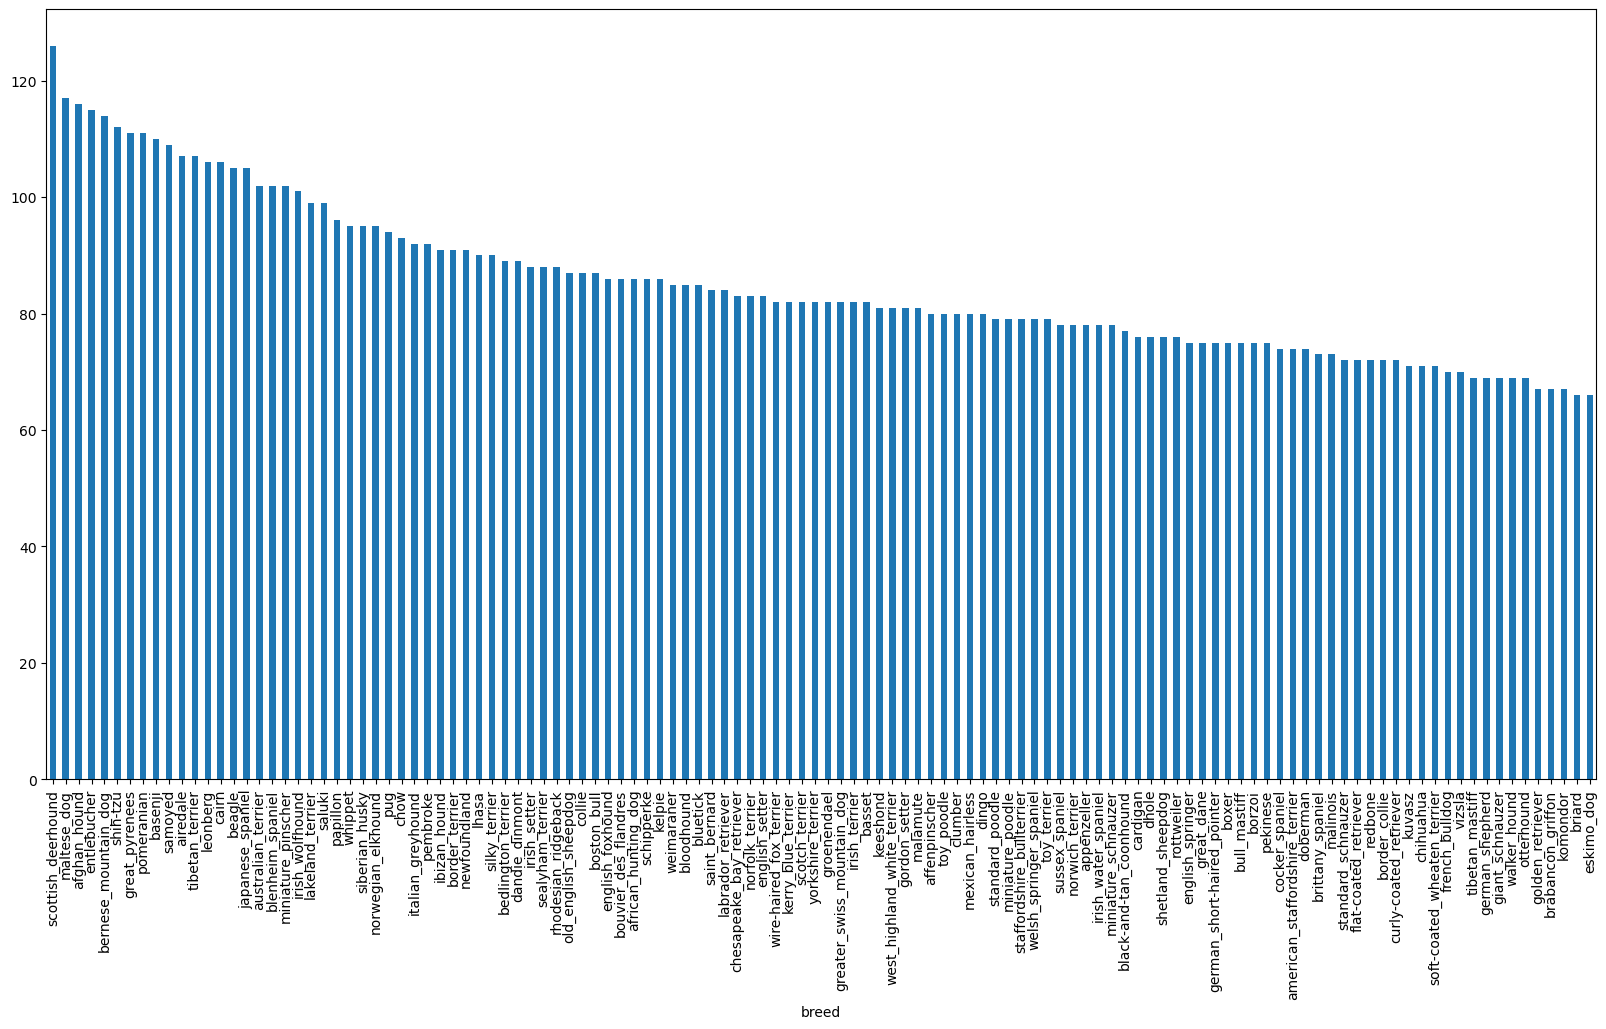

In [6]:
# How many images are there for each breed
labels_csv.value_counts('breed').plot.bar(figsize=(20,10));

In [7]:
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [8]:
# What's the median number of images per class?
labels_csv['breed'].value_counts().median()

82.0

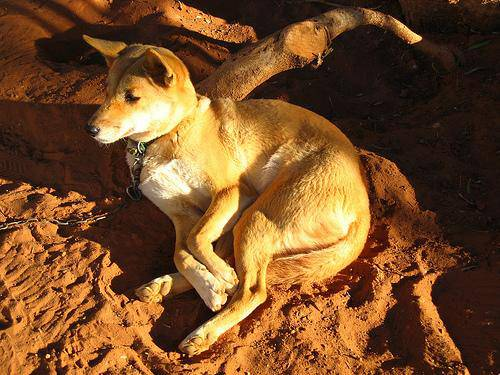

In [9]:
# Let's view an image 
from IPython.display import Image
Image('train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

### Getting images and their labels

Let's get a list of all of our image file pathnames.

In [10]:
# Create pathnames from image ID's 
filenames = ['train/' + fname + ".jpg" for fname in labels_csv['id']]

# Check the first 10
filenames[:10]

['train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'train/001cdf01b096e06d78e9e5112d419397.jpg',
 'train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'train/002a283a315af96eaea0e28e7163b21b.jpg',
 'train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
# Check wether number of filenames matches number of actual image files
import os 
if len (os.listdir('train/')) == len(filenames):
    print("Filenames match actual amount of files!! Proceed.")
else:
    print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!! Proceed.


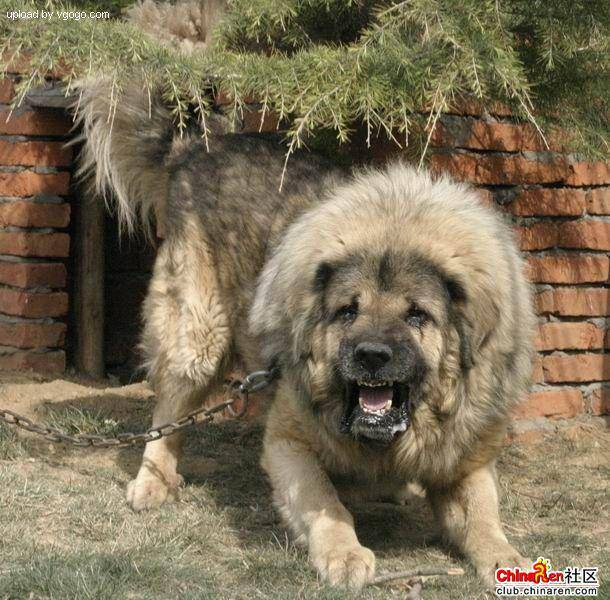

In [12]:
# One more check
Image(filenames[9000])

In [13]:
labels_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [14]:
labels_csv['breed'][9000]

'tibetan_mastiff'

In [15]:
labels_csv['id'][800]

'13d42ef52eb6c649c14cb9ffa8b6fba4'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [16]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [17]:
len (labels)

10222

In [18]:
# see if number of labels matches the number fo filenames
if len(labels) == len(filenames):
    print("Number of labels matches number of filenmaes !")
else:
    print("Number of labels does not match number of filenames, check data directories !")

Number of labels matches number of filenmaes !


In [19]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [20]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [21]:
len (boolean_labels)

10222

In [22]:
# Turning boolean array into integers
print(labels[0]) # Original label
print(np.where(unique_breeds == labels[0])) #index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [23]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [24]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [25]:
filenames[:10]

['train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'train/001cdf01b096e06d78e9e5112d419397.jpg',
 'train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'train/002a283a315af96eaea0e28e7163b21b.jpg',
 'train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg']

## Creating our own validation set

since the dataset from Kaggle doesn't come with a validation set, we're going to create our own

In [26]:
# Setup X and y variables
X = filenames
y = boolean_labels

In [27]:
len(filenames)

10222

We're going to start off experimenting with ~1000 images and increase as needed.

In [28]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 

In [29]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

np.random.seed(42)
# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                 y[:NUM_IMAGES],
                                                 test_size=0.2,
                                                 random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [30]:
# Let's see the training data
X_train[:5], y_train[:2]

(['train/00bee065dcec471f26394855c5c2f3de.jpg',
  'train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, Fa

## Preprocessing Images (Turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:

* 1.Take an image filepath as input
* 2.Use TensorFlow to read the file and save it to a variable, `image`
* 3.Turn our `image` (a jpg) into Tensors
* 4.Normalize our image (convert color channel values from 0-255 to 0-1)
* 5.Resize the `image` to be a shape of (224,224) 
* 6.Return the modified `image

Before we do, let's see what importing an image looks like.

In [31]:
# Convert image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape


(257, 350, 3)

In [32]:
image.max(), image.min()

(255, 0)

In [33]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [34]:
# turn image into a tensor
tf.constant(image)[:2]

2024-06-28 13:47:30.887914: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22502 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-06-28 13:47:30.888654: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22502 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:31:00.0, compute capability: 8.6
2024-06-28 13:47:30.889345: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22502 MB memory:  -> device: 2, name: NVIDIA RTX A5000, pci bus id: 0000:b1:00.0, compute capability: 8.6
2024-06-28 13:47:30.889712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22502 MB memory:  -> device: 3, name: NVIDIA RTX A5000, pci bus id: 0000:ca:00.0, 

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.


* 1.Take an image filepath as input
* 2.Use TensorFlow to read the file and save it to a variable, `image`
* 3.Turn our `image` (a jpg) into Tensors
* 4.Normalize our image (convert color channel values from 0-255 to 0-1)
* 5.Resize the `image` to be a shape of (224,224) 
* 6.Return the modified `image`

In [35]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path):
    
    """
    Takes an image file path and turns the image into a Tensor.
    """
    
    
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 color channels(Read, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the color channel values from 0-225 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value (224,224)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    
    return image

## Turning our data into batches

We trun our data into batches, because we have about 10,000+ images in our dataset and they all might not fit into the memory. So we are going to process 32(batch size) images at a time.

In order to use Tensorflow effectively, we need our data in the form of Tensor tuples which look like this:(image, label).

In [36]:
# Create a simple function to return a tuple (image, label)

def get_image_label(image_path, label):
    
    """
    
    Take an image file path name and the associated label, process the image and return a tuple of (image, label).
    """
    
    image = process_image(image_path)
    return image,label

In [37]:
# Demo of the above
(process_image(X[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data(`X`,`y`) into batches!

In [38]:
# Define a batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
    
    """
    Create batches of data out of image (X) and label (y) pairs.
    shuffels the data if it's training data but doesn't shuffle if it's validation data.
    Also accept test data as input (no labels).
    """
    
    # If the data is a test dataset, we probably don't have any labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only filepaths (no lables)
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    
    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                 tf.constant(y))) # labels
        
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    
    else:
        print("Creating training data batches...")
        # Turn filepaths and labels into tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                 tf.constant(y)))
        
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffeling images
        data = data.shuffle(buffer_size=len(X))
        
        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)
        
        # Turn the training data into batches 
        data_batch = data.batch(BATCH_SIZE)
        
    return data_batch
        
    
    
    
    


In [39]:
# Creating training and validation data batches
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [40]:
# Checkout the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them.

In [41]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch

def show_25_images(images, labels):

    """
    Displays a plot of 25 images and their labels from a data batch.
    
    """
    
    # Setup the figure
    plt.figure(figsize=(10,10))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5,5,i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis("off")
    

In [42]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [43]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[7.90591776e-01, 7.77387917e-01, 8.26274514e-01],
          [8.06862354e-01, 7.93480277e-01, 8.42426240e-01],
          [7.85520971e-01, 7.74544597e-01, 8.22688639e-01],
          ...,
          [7.70203769e-01, 7.74125338e-01, 7.81968474e-01],
          [7.72829294e-01, 7.76750863e-01, 7.84593999e-01],
          [7.78781652e-01, 7.82703221e-01, 7.90546358e-01]],
 
         [[7.64664173e-01, 7.17994094e-01, 7.46162832e-01],
          [7.86517024e-01, 7.39744961e-01, 7.67913818e-01],
          [7.84436822e-01, 7.39040613e-01, 7.67209470e-01],
          ...,
          [7.71042466e-01, 7.74964035e-01, 7.90650308e-01],
          [7.72993624e-01, 7.76915193e-01, 7.92601466e-01],
          [7.81162560e-01, 7.85084128e-01, 8.00770402e-01]],
 
         [[7.69083500e-01, 6.89706683e-01, 6.97900116e-01],
          [7.59910941e-01, 6.80534124e-01, 6.88744426e-01],
          [7.62731612e-01, 6.83354795e-01, 6.91337168e-01],
          ...,
          [7.81406164e-01, 7.77484596e-01, 8.0101

In [44]:
len(train_images), len(train_labels)

(32, 32)

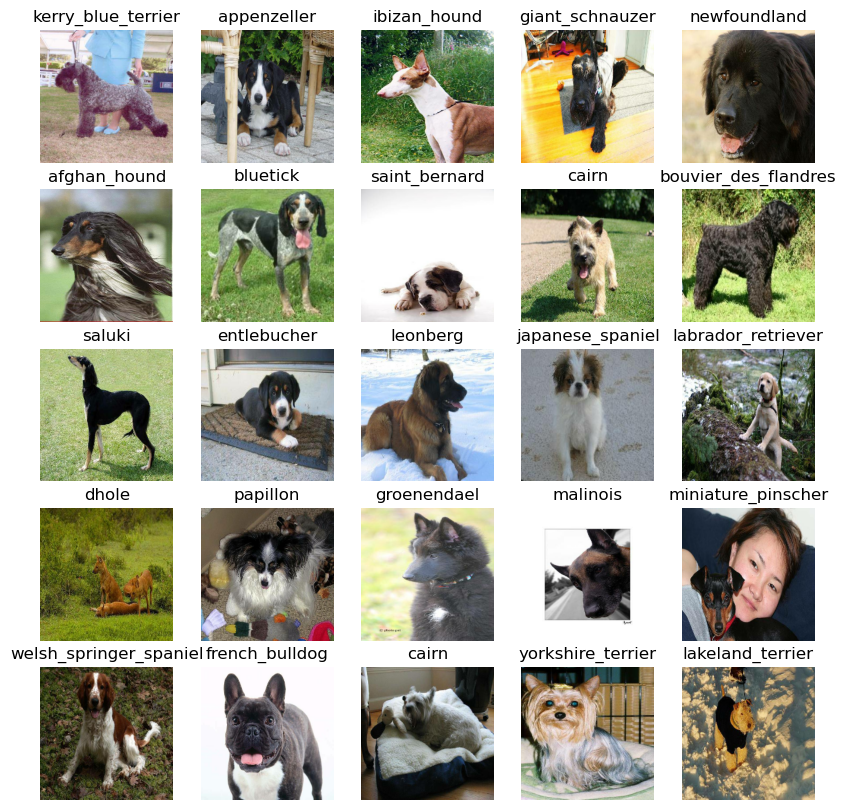

In [45]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

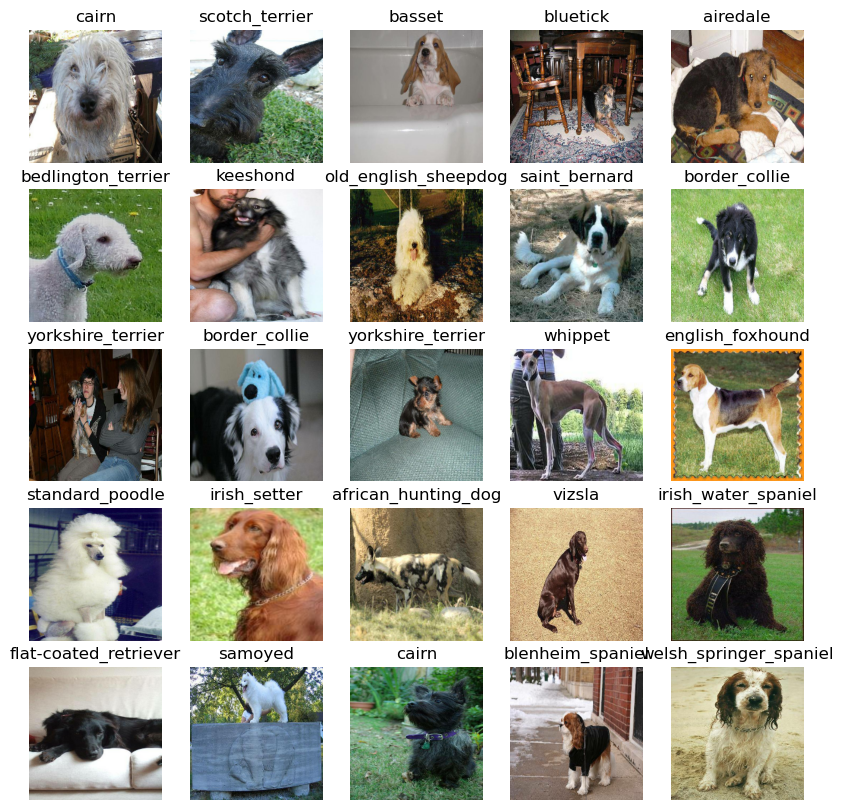

In [46]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images,val_labels)

## Building a Model

Before we build a model, there are a few things we need to define:

* The input shape(our images shape, in the form of Tensors) to our model.
* The output shape(image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.

In [47]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from Tensorflow Hub
MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/large-075-224-classification/1"

In [48]:
INPUT_SHAPE, OUTPUT_SHAPE

([None, 224, 224, 3], 120)

Now we've got our inputs, outputs and model ready to go.
Let's put them together into a keras deep learning model!

Knowing this, let's create a function which:


* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion.
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

### All of these steps can be found here: https://www.tensorflow.org/guide/keras

### The following code solve the problem of hub using keras version 3 that makes problem for the code

In [49]:
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("TF Hub Version: ", hub.__version__)


TF version:  2.16.1
TF Hub Version:  0.16.1


In [50]:
import tensorflow as tf

version_fn = getattr(tf.keras, "version", None)
print("TF Version: " + tf.__version__)
print("TF Keras Version: " + version_fn())

TF Version: 2.16.1
TF Keras Version: 3.3.3


In [51]:
# Because of incompatibility between Keras version 3 and TensorFlow Hub, we're going to import tf_keras
import tf_keras as tfk

In [52]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", MODEL_URL)

  # Setup the model layers
    model = tfk.Sequential([
    hub.KerasLayer(model_url,trainable=True, arguments=dict(batch_norm_momentum=0.997)), # Layer 1 (input layer)
    tfk.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
    model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
    model.build(INPUT_SHAPE)

    return model

In [53]:
model = create_model()
model.summary()

Building model with: https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/large-075-224-classification/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              4013897   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 4134137 (15.77 MB)
Trainable params: 4115049 (15.70 MB)
Non-trainable params: 19088 (74.56 KB)
_________________________________________________________________


In [54]:
outputs = np.ones(shape = (1,1,1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

## Creating Callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a Tensorboard callback, we need to do 3 things:

* 1.Load the TensorBoard notebook extension
* 2.Create a TensorBoard callback which is able to save logs to a directory and pass it to our mode's `fit()` function.
* 3.Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training).


In [55]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [56]:
# from tf_keras.callbacks import TensorBoard

In [57]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join("logs",
                         # Make it so the logs get tracked whenever we run an experiment
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tfk.callbacks.TensorBoard(logdir)
    

### Early Stopping Callbacks

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.


In [58]:
# Create early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor="val_accuracy",
                                                 patience = 3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [59]:
NUM_EPOCHS = 100 #

In [60]:
# import ipywidgets as widgets
# from IPython.display import display

# # Create a slider
# NUM_EPOCHS = widgets.IntSlider(
#     value=50,
#     min=10,
#     max=100,
#     step=1,
#     description='NUM_EPOCHS:',
#     continuous_update=False
# )

# # Display the slider
# display(NUM_EPOCHS)

# # Create an output widget to display the slider value
# output = widgets.Output()

# # Function to handle slider value changes
# def on_slider_change(change):
#     with output:
#         output.clear_output()
#         print(f'Epochs value: {change["new"]}')

# # Attach the change event handler to the slider
# NUM_EPOCHS.observe(on_slider_change, names='value')

# # Display the output widget
# display(output)


In [61]:
print(NUM_EPOCHS)

100


In [62]:
# Check to make sure we're still running on a GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "Not available")

GPU available


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use.
* Return the model

In [63]:
# Build a function to train and return a trained model

def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model()
    
    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()
    
    # Fit the model to the data passing it the callbacks we created 
    model.fit(x = train_data,
             epochs = NUM_EPOCHS,
             validation_data = val_data,
             validation_freq = 1,
             callbacks = [tensorboard,early_stopping])
    # Return the fitted model
    return model
    

In [64]:
# Fit the model to the data
model = train_model()

Building model with: https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/large-075-224-classification/1
Epoch 1/100


2024-06-28 13:48:10.109327: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8904
I0000 00:00:1719607692.868845 3297560 service.cc:145] XLA service 0x7fefc5750770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719607692.868891 3297560 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
I0000 00:00:1719607692.868898 3297560 service.cc:153]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
I0000 00:00:1719607692.868903 3297560 service.cc:153]   StreamExecutor device (2): NVIDIA RTX A5000, Compute Capability 8.6
I0000 00:00:1719607692.868909 3297560 service.cc:153]   StreamExecutor device (3): NVIDIA RTX A5000, Compute Capability 8.6
2024-06-28 13:48:12.878135: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719607693.012227 329

25/25 [==============================] - 51s 75ms/step - loss: 5.4670 - accuracy: 0.1025 - val_loss: 4.0374 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 1s 43ms/step - loss: 1.2742 - accuracy: 0.8763 - val_loss: 4.0695 - val_accuracy: 0.3350
Epoch 3/100
25/25 [==============================] - 1s 44ms/step - loss: 0.8427 - accuracy: 0.9825 - val_loss: 4.1644 - val_accuracy: 0.3400
Epoch 4/100
25/25 [==============================] - 1s 47ms/step - loss: 0.7944 - accuracy: 0.9925 - val_loss: 3.9415 - val_accuracy: 0.4000
Epoch 5/100
25/25 [==============================] - 2s 70ms/step - loss: 0.7741 - accuracy: 0.9975 - val_loss: 4.2220 - val_accuracy: 0.4050
Epoch 6/100
25/25 [==============================] - 2s 93ms/step - loss: 0.7708 - accuracy: 0.9987 - val_loss: 4.2458 - val_accuracy: 0.4100
Epoch 7/100
25/25 [==============================] - 2s 80ms/step - loss: 0.7621 - accuracy: 1.0000 - val_loss: 4.0981 - val_accuracy: 0.4400
Epoch 8/100
25/25

## Checking the TensorBoard logs

The TensorBoard magic function(`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [65]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 3294854), started 0:55:26 ago. (Use '!kill 3294854' to kill it.)

## Making and evaluating predictions using a trained model

In [66]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [67]:
# Make predictions on the validation data(not used on train on)
predictions = model.predict(val_data, verbose=1)
predictions


7/7 [==============================] - 1s 16ms/step


array([[8.44712940e-06, 1.41897872e-05, 2.82555082e-08, ...,
        4.85104938e-05, 1.04997694e-01, 2.71303463e-07],
       [2.11538809e-05, 8.59530246e-07, 3.09533743e-06, ...,
        1.73079940e-07, 6.07167203e-05, 1.52257975e-08],
       [8.59798718e-07, 3.32672120e-04, 2.77883755e-05, ...,
        8.61121225e-04, 4.92199149e-04, 3.31230112e-05],
       ...,
       [7.16414021e-08, 1.60873213e-04, 3.02154626e-06, ...,
        7.49194714e-06, 3.44595854e-08, 1.21128107e-06],
       [6.17669575e-05, 1.14653712e-05, 9.03234541e-05, ...,
        1.61761363e-05, 1.34276444e-04, 1.77040081e-02],
       [8.16218403e-07, 4.14661514e-07, 3.61079373e-07, ...,
        1.97772260e-06, 7.66376559e-07, 3.22323956e-07]], dtype=float32)

In [68]:
predictions[0]

array([8.44712940e-06, 1.41897872e-05, 2.82555082e-08, 7.95896864e-04,
       7.04768752e-07, 2.89609034e-06, 1.47268325e-01, 1.44368229e-07,
       2.53300477e-05, 5.88401363e-08, 1.10655033e-03, 2.34931576e-07,
       1.82972381e-05, 4.53523143e-07, 1.90994360e-05, 1.50424819e-06,
       3.58675129e-06, 6.91257650e-04, 1.85229714e-04, 4.54839650e-08,
       7.89316487e-04, 5.08646963e-07, 5.89201306e-07, 8.24694559e-02,
       9.54882125e-06, 5.60394947e-05, 2.36811442e-03, 6.67558936e-07,
       2.54447350e-05, 1.74499507e-06, 7.77435052e-05, 1.68351212e-03,
       1.35236664e-03, 2.08210190e-06, 6.10438383e-06, 3.59651409e-02,
       5.75344714e-08, 3.44568934e-06, 3.31189881e-06, 4.29633644e-07,
       3.14926682e-03, 6.08464006e-06, 8.80538937e-06, 4.98224108e-05,
       3.57494457e-07, 9.50012691e-06, 4.96432904e-06, 4.71852587e-07,
       1.58070363e-02, 6.84816550e-05, 1.14080476e-05, 8.72061704e-04,
       2.25055069e-02, 1.15936564e-05, 4.50578682e-07, 1.12109565e-05,
      

In [69]:
np.sum(predictions[0])

1.0

In [70]:
# First prediction
index = 42
print(predictions[0])
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[8.44712940e-06 1.41897872e-05 2.82555082e-08 7.95896864e-04
 7.04768752e-07 2.89609034e-06 1.47268325e-01 1.44368229e-07
 2.53300477e-05 5.88401363e-08 1.10655033e-03 2.34931576e-07
 1.82972381e-05 4.53523143e-07 1.90994360e-05 1.50424819e-06
 3.58675129e-06 6.91257650e-04 1.85229714e-04 4.54839650e-08
 7.89316487e-04 5.08646963e-07 5.89201306e-07 8.24694559e-02
 9.54882125e-06 5.60394947e-05 2.36811442e-03 6.67558936e-07
 2.54447350e-05 1.74499507e-06 7.77435052e-05 1.68351212e-03
 1.35236664e-03 2.08210190e-06 6.10438383e-06 3.59651409e-02
 5.75344714e-08 3.44568934e-06 3.31189881e-06 4.29633644e-07
 3.14926682e-03 6.08464006e-06 8.80538937e-06 4.98224108e-05
 3.57494457e-07 9.50012691e-06 4.96432904e-06 4.71852587e-07
 1.58070363e-02 6.84816550e-05 1.14080476e-05 8.72061704e-04
 2.25055069e-02 1.15936564e-05 4.50578682e-07 1.12109565e-05
 6.28215204e-08 2.33463172e-04 3.28058486e-05 2.35790148e-01
 1.90722062e-07 6.83633772e-08 8.33412770e-08 2.00962268e-06
 1.01733327e-04 4.768350

In [71]:
unique_breeds[24]

'brittany_spaniel'

Having the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** prediction probabilities are also known as confidence levels.

In [72]:
# Turn prediction probabilities into their respective label (easier to understand)

def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    
    return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities

pred_label = get_pred_label(predictions[81])
pred_label


'dingo'

In [73]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels(truth labels).

In [74]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
    
    """
    
    images = []
    labels = []
    
    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

# Unbatchify the validation data

val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]
    

2024-06-28 13:48:59.523640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get :
* Prediction labels
* Validation Labels(Truth labels)
* Validation images

Let's make some function to make these all a bit more visualize.

We'll create a function which:
* Takes an array of prediction probabilities, and array of truth labels and an array of images and integers.
* Convert the prediction probabilities to predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.



In [75]:
  def plot_pred(prediction_probabilities, labels, images, n=1):
        """
        View the prediction, ground truth and image for sample n
        """
        
        pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
        
        # Get the pred label
        pred_label = get_pred_label(pred_prob)
        
        # plot image & remove ticks
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        
        # Change the color of the title depending on if the prediction is right or wrong
        if pred_label == true_label:
            color = "green"
        else:
            color = "red"
            
        # Change plot title to be predicted, probability of prediction and truth label
        plt.title("{} {:2.0f}% {}".format(pred_label,
                                          np.max(pred_prob)*100,
                                          true_label),
                                            color = color)
                
        
        

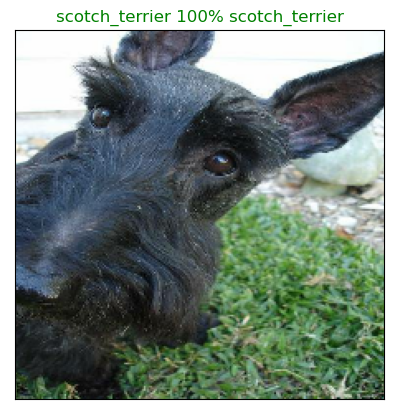

In [76]:
plot_pred(prediction_probabilities=predictions,
         labels=val_labels,
         images=val_images)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:

* Take an input of prediction probabilities array and a ground truth array and an integer
* Find the prediction using `get_pred_label()`
* Find the top 10:
    * Prediction probabilities indexes
    * Prediction probabilities values
    * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green

In [77]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    Plus the top 10 highest prediction confidences along with the truth label for sample n.
    """
    
    pred_prob, true_label = prediction_probabilities[n], labels[n]
    
    # Get the predicted label
    pred_label = get_pred_label(pred_prob)
    
    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    # find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]
    
    # Setup plot 
    top_plot = plt.bar(np.arange(len(top_10_pred_indexes)),
                      top_10_pred_values,
                      color = "grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
              labels= top_10_pred_labels,
              rotation = "vertical")
    
    # Change color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
    else:
        pass
    
    
    

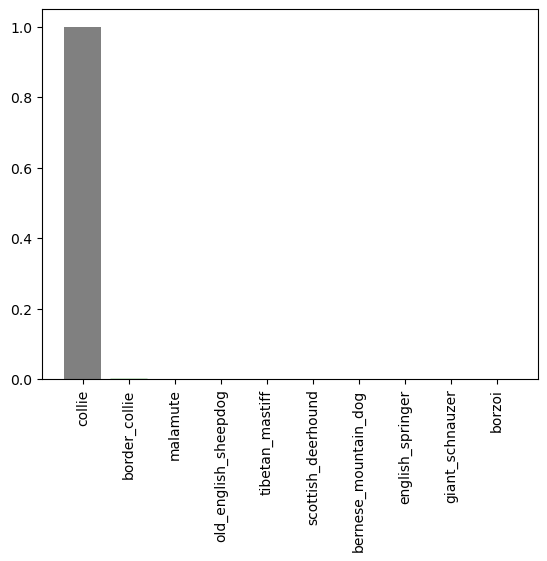

In [85]:
plot_pred_conf(prediction_probabilities=predictions,
              labels=val_labels,
              n = 9)

Now we've got some function to help us visualize our predictions and evaluate our model, let's check out a few.

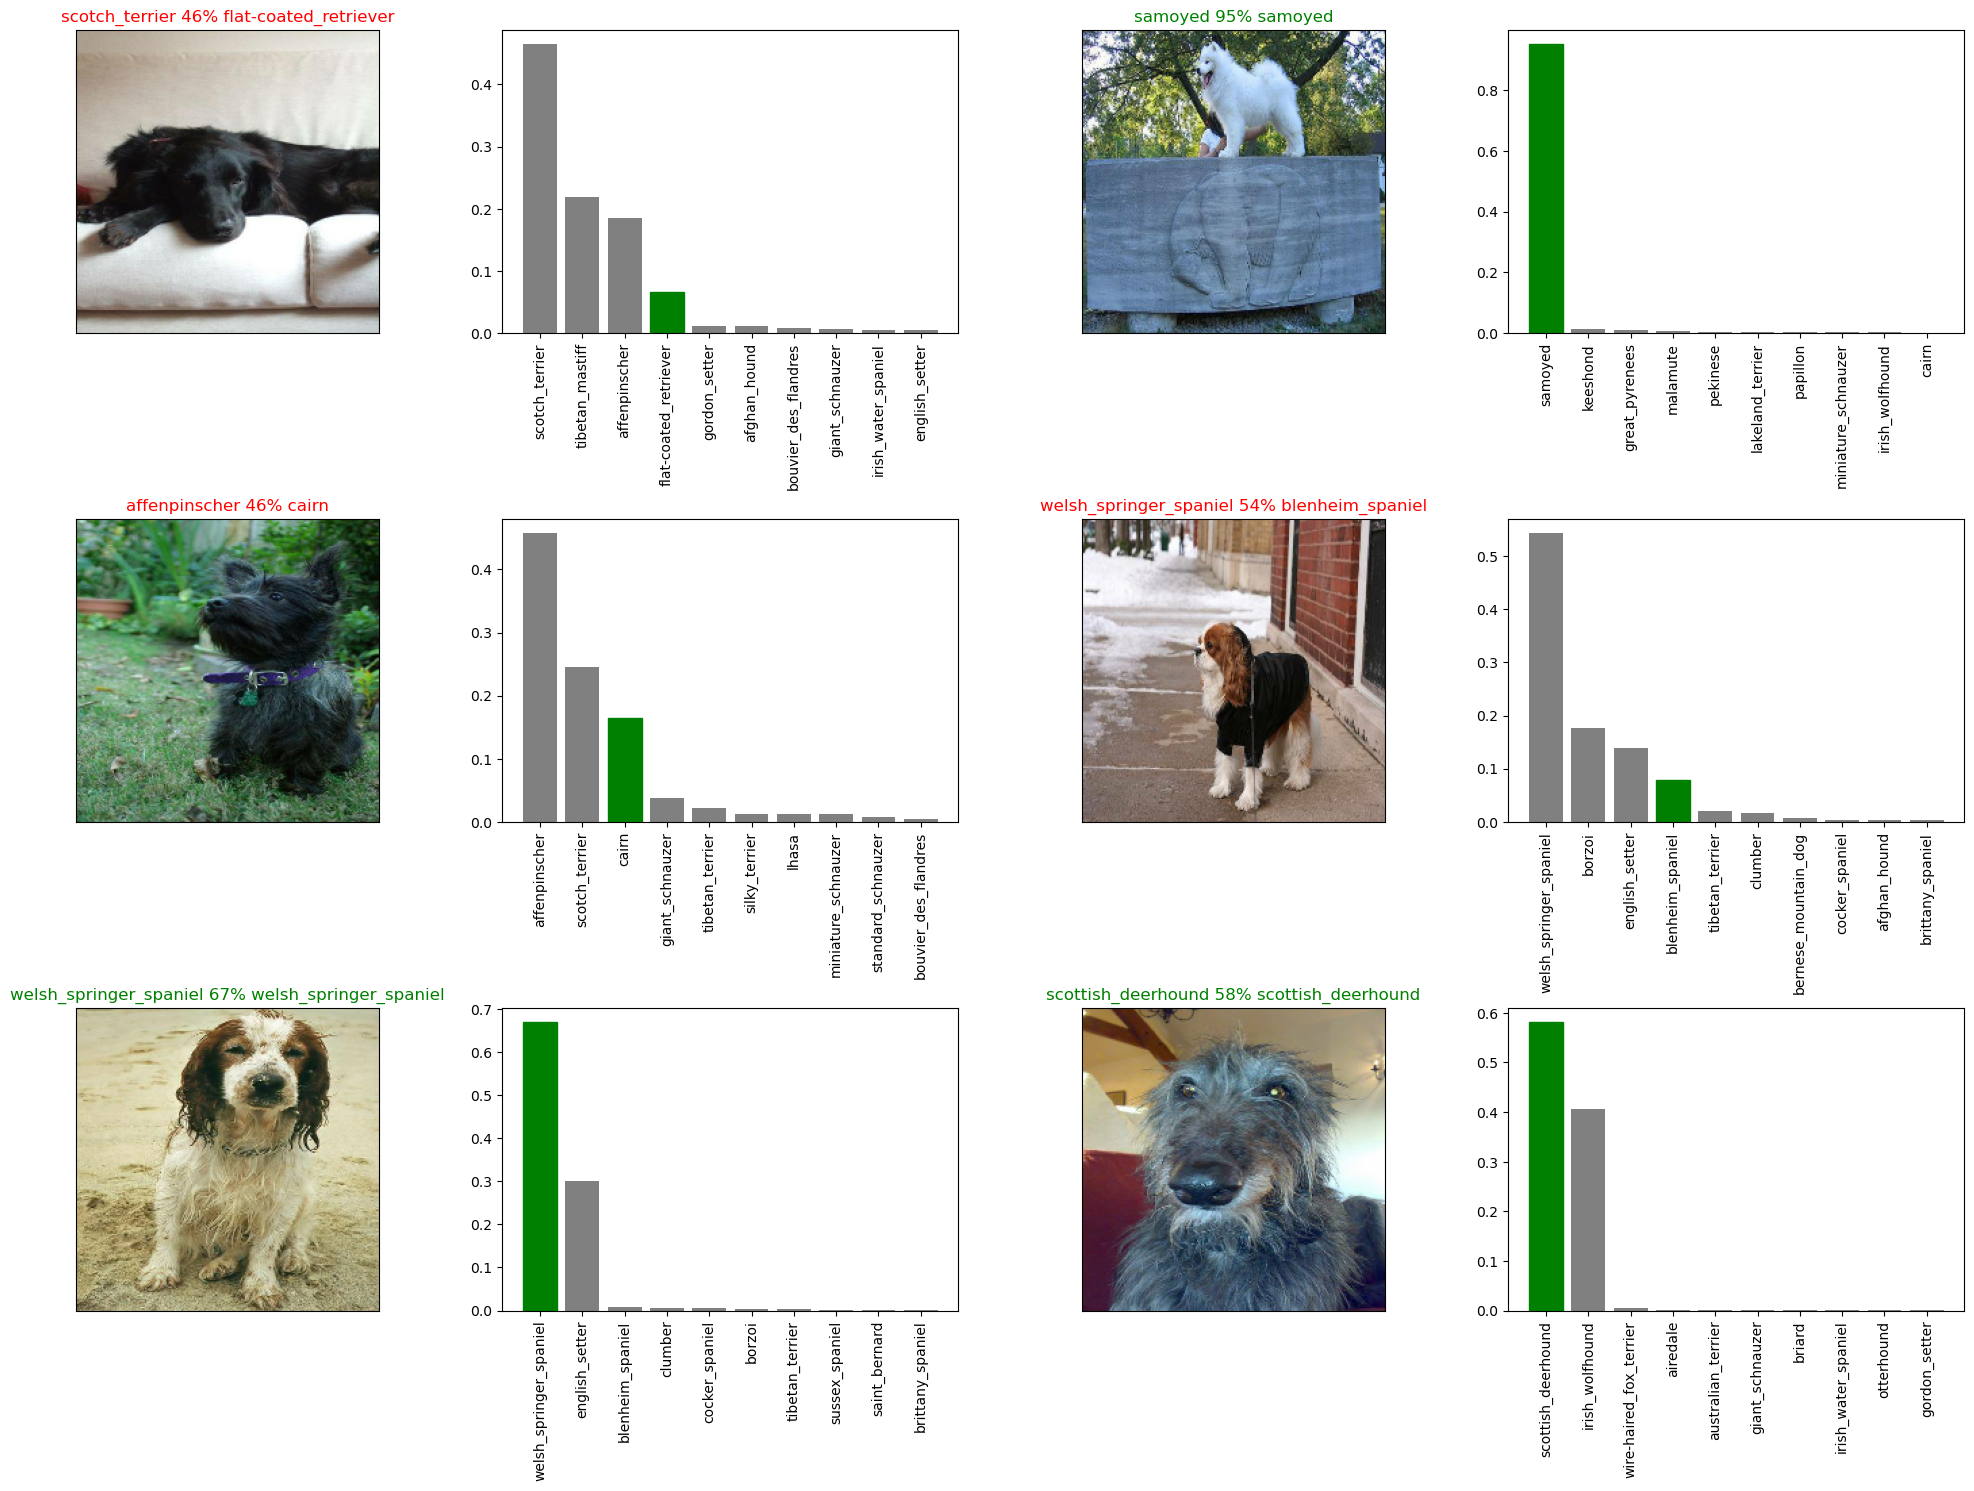

In [86]:
# Let's check out a few predictions and their different values

i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities=predictions,
             labels= val_labels,
             images=val_images,
             n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities=predictions,
                  labels=val_labels,
                  n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading a trained model

In [96]:
# Create a function to save a model
def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appends a suffix (string).
    """
    
    # Create a model directory pathname with current time
    modeldir = os.path.join("models" ,datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path = modeldir+ "-" + suffix + ".h5" # save format of model
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    return model_path
    

In [97]:
# Create a function to load a trained model
def load_model(model_path):
    """
    Loads a saved model from a specified path.
    """
    
    print(f"Loading saved model from: {model_path}")
    model = tfk.models.load_model(model_path,
                                 custom_objects={"KerasLayer":hub.KerasLayer})
    return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [98]:
# Save our model traine on 1000 images
save_model(model, suffix="10000-images-mobilenetv3-Adam")

Saving model to: models/20240628-15091719612588-10000-images-mobilenetv3-Adam.h5...


/home/NETID/rrahimid/.local/lib/python3.9/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'models/20240628-15091719612588-10000-images-mobilenetv3-Adam.h5'

In [99]:
# Load a trained model
loaded_1000_image_model = load_model("models/20240628-15091719612588-10000-images-mobilenetv3-Adam.h5")

Loading saved model from: models/20240628-15091719612588-10000-images-mobilenetv3-Adam.h5


In [101]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 0s 17ms/step - loss: 3.7495 - accuracy: 0.4650


[3.7494723796844482, 0.4650000035762787]

In [102]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 2s 21ms/step - loss: 3.7495 - accuracy: 0.4650


[3.7494723796844482, 0.4650000035762787]

## Training a bid dog model  🐶 (on the full data)

In [103]:
len(X), len(y)

(10222, 10222)

In [104]:
X[:10]

['train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'train/001cdf01b096e06d78e9e5112d419397.jpg',
 'train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'train/002a283a315af96eaea0e28e7163b21b.jpg',
 'train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [105]:
len(X_train)

800

In [106]:
# Create a data batch with the full data set
full_data = create_data_batches(X,y)

Creating training data batches...


In [107]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [108]:
# Create a model for full model
full_model = create_model()

Building model with: https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/large-075-224-classification/1


In [109]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor valildation accuracy
full_model_early_stopping = tfk.callbacks.EarlyStopping(monitor="accuracy", patience=3)

In [110]:
# Fit the full Model to the full data
full_model.fit(x=full_data,
              epochs=NUM_EPOCHS,
              callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 53s 70ms/step - loss: 2.9162 - accuracy: 0.4742
Epoch 2/100
320/320 [==============================] - 18s 57ms/step - loss: 1.8498 - accuracy: 0.6994
Epoch 3/100
320/320 [==============================] - 19s 58ms/step - loss: 1.5122 - accuracy: 0.7807
Epoch 4/100
320/320 [==============================] - 23s 72ms/step - loss: 1.4261 - accuracy: 0.8120
Epoch 5/100
320/320 [==============================] - 18s 57ms/step - loss: 1.3423 - accuracy: 0.8389
Epoch 6/100
320/320 [==============================] - 17s 54ms/step - loss: 1.2964 - accuracy: 0.8574
Epoch 7/100
320/320 [==============================] - 14s 44ms/step - loss: 1.3231 - accuracy: 0.8560
Epoch 8/100
320/320 [==============================] - 23s 73ms/step - loss: 1.2825 - accuracy: 0.8663
Epoch 9/100
320/320 [==============================] - 16s 50ms/step - loss: 1.2285 - accuracy: 0.8854
Epoch 10/100
320/320 [==============================] - 19s 58ms/step - l

In [111]:
save_model(full_model, suffix = "full-image-set-mobilenetv3-Adam")

Saving model to: models/20240628-15301719613809-full-image-set-mobilenetv3-Adam.h5...


/home/NETID/rrahimid/.local/lib/python3.9/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'models/20240628-15301719613809-full-image-set-mobilenetv3-Adam.h5'

In [112]:
#Load in the full model
loaded_full_model = load_model('models/20240628-15301719613809-full-image-set-mobilenetv3-Adam.h5')

Loading saved model from: models/20240628-15301719613809-full-image-set-mobilenetv3-Adam.h5


## Making predictions on the test dataset


Since our model has been trained on the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels).
* Make a predictions array by passing the test batches to the `predict()` metod called on our model.

In [113]:
# Load test image filenames

test_path = "test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['test/33fdf388402e678d94203911ec26c63e.jpg',
 'test/c65c06ac8a136ae9480b172e36eebc98.jpg',
 'test/3822d373e39ed9e4807df83ef3b20ae1.jpg',
 'test/d73332e902de7569ca81511c89ea029a.jpg',
 'test/a2e03e4bca79b6858bdc707142dd8391.jpg',
 'test/d7d6e12e5661934b4de87c44f2018250.jpg',
 'test/40d05f99a7bdfab03213248a2457678c.jpg',
 'test/996254e59f86a920027b43542c177b7d.jpg',
 'test/c9b49c0d6380bfb7a8c214e6f319b413.jpg',
 'test/3ab68939f1a29c1356d33ac084dc3fb4.jpg']

In [114]:
len(test_filenames)

10357

In [115]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [116]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [117]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,verbose=1)

324/324 [==============================] - 4s 10ms/step


In [118]:
# Save the prediction (NumPy array ) to csv file (for access later)
np.savetxt('preds.array.csv', test_predictions, delimiter= ",")

In [119]:
test_predictions = np.loadtxt('preds.array.csv', delimiter=",")

In [120]:
test_predictions[:10]

array([[5.74423836e-07, 2.05617481e-10, 5.20066066e-14, ...,
        4.29145075e-09, 4.34501324e-08, 2.93077596e-06],
       [5.58193392e-07, 7.59456142e-08, 1.54431636e-05, ...,
        5.93759702e-04, 1.62961328e-07, 2.13628550e-06],
       [2.96342867e-10, 3.04640133e-11, 6.01717375e-07, ...,
        5.17191567e-10, 1.78017982e-11, 1.70239586e-11],
       ...,
       [1.58988136e-26, 9.57367260e-17, 1.02033595e-19, ...,
        4.72150695e-22, 3.73099531e-19, 2.41933164e-23],
       [6.30147823e-26, 1.17731690e-16, 1.94052841e-22, ...,
        7.35138756e-21, 4.16175095e-26, 8.05545679e-22],
       [3.83166728e-11, 2.51867568e-05, 7.92731245e-12, ...,
        6.30083876e-12, 7.28200860e-08, 7.67604789e-08]])

In [121]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle

Looking at the kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breed.

To get the data in this format, we'll:

* Create a pandas DataFrame with an ID columns as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths.
* ADD data (the prediction probabilities) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [122]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=['id'] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [123]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df['id'] = test_ids

In [124]:
preds_df.head()

id affenpinscher afghan_hound  \
0  33fdf388402e678d94203911ec26c63e           NaN          NaN   
1  c65c06ac8a136ae9480b172e36eebc98           NaN          NaN   
2  3822d373e39ed9e4807df83ef3b20ae1           NaN          NaN   
3  d73332e902de7569ca81511c89ea029a           NaN          NaN   
4  a2e03e4bca79b6858bdc707142dd8391           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [125]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  33fdf388402e678d94203911ec26c63e   5.744238e-07  2.056175e-10   
1  c65c06ac8a136ae9480b172e36eebc98   5.581934e-07  7.594561e-08   
2  3822d373e39ed9e4807df83ef3b20ae1   2.963429e-10  3.046401e-11   
3  d73332e902de7569ca81511c89ea029a   2.372449e-04  3.195477e-04   
4  a2e03e4bca79b6858bdc707142dd8391   9.187101e-09  2.464592e-11   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         5.200661e-14  8.695476e-10                    9.291309e-10   
1         1.544316e-05  3.106509e-05                    1.132236e-01   
2         6.017174e-07  6.985303e-11                    1.143711e-08   
3         5.696828e-04  9.105888e-06                    1.856863e-04   
4         7.986094e-09  1.995255e-08                    1.956644e-09   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  2.618487e-09        1.285485e-10  3.750525e-12  1.171897e-14  ...   
1  4.102505e-05        7.052869e-05  2.320928e-05  9.346149e-06  ...   
2  6.379319e-13        1.067629e-10  2.505896e-08  2.829851e-09  ...   
3  9.427619e-06        8.561525e-03  5.950161e-08  8.844109e-09  ...   
4  6.509289e-09        6.025198e-05  3.787876e-11  1.003835e-14  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  1.963953e-12  2.723224e-11  2.294016e-11  3.385202e-09  2.345279e-11   
1  3.259445e-09  4.701751e-07  3.042316e-05  1.436997e-04  4.976436e-05   
2  1.693756e-10  8.840981e-12  1.118354e-07  2.697430e-10  1.074451e-07   
3  1.052717e-07  1.055337e-06  6.042318e-08  8.645026e-06  1.246423e-04   
4  2.051116e-05  2.822578e-10  2.586833e-08  1.000082e-13  1.283596e-07   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            7.506513e-10                 1.261130e-09  4.291451e-09   
1            1.187507e-06                 3.612886e-06  5.937597e-04   
2            1.830435e-12                 6.988905e-10  5.171916e-10   
3            8.603829e-04                 6.956079e-06  1.020587e-05   
4            1.002833e-12                 9.157272e-09  5.091346e-10   

   wire-haired_fox_terrier  yorkshire_terrier  
0             4.345013e-08       2.930776e-06  
1             1.629613e-07       2.136286e-06  
2             1.780180e-11       1.702396e-11  
3             1.500827e-07       2.141678e-06  
4             6.319549e-08       6.238798e-06  

[5 rows x 121 columns]

In [126]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("full_model_predictions_submission_1_mobilenetV3.csv",
               index = False)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict` method.
* Convert the prediction output porbabilities to preditions labels.
* Compare the predicted labels to the custom images.

In [143]:
# Get custom image filepaths
custom_path = 'My-Dog-Photo/'
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [144]:
custom_image_paths

['My-Dog-Photo/dog-puppy-on-garden-royalty-free-image-1586966191.jpg',
 'My-Dog-Photo/KOA_Nassau_2697x1517.jpg',
 'My-Dog-Photo/360_F_559274893_O9iSRQwTKIkAooNTglilMgx2yMcXK9Or.jpg']

In [145]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [146]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 0s 167ms/step


In [147]:
custom_preds.shape

(3, 120)

In [148]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['labrador_retriever', 'kuvasz', 'rottweiler']

In [149]:
# Get custom images (our unbatchify() function won't work since ther aren't labels... maybe we could fix this later)
custom_images = []

# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

2024-06-28 17:03:45.086356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


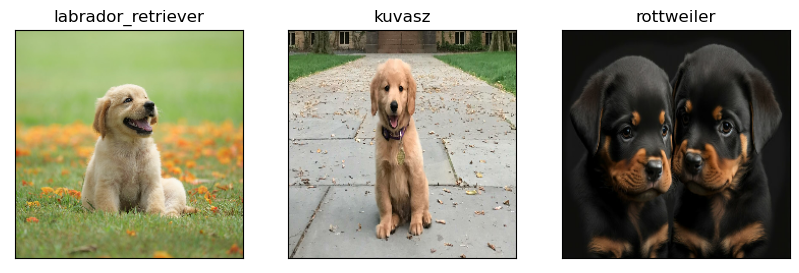

In [151]:
# check custom image predictions
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
    plt.subplot(1,3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_pred_labels[i])
    plt.imshow(image)